# Training Models to Classify Driver Behaviors

In [124]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import umap
from sklearn.preprocessing import LabelEncoder
from tsfresh.feature_extraction import extract_features
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, f1_score, accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

FOLDER_NAME = 'ufscar'

In [78]:
def create_sliding_windows(data, labels, window_size=15, step_size=5):
    # This function returns the sliding windows and the labels for each window
    # If output_3d is True, the output will be a 3D array, otherwise it will be a 2D array
    # The 2D array is (num_samples, num_features), useful for ML and the 3D array is (num_samples, window_size/time_steps, num_features), useful for RNNs
    # The difference is that the window is not flattened in the 3D array
    X = []
    y = []
    for k in range(len(data)):
        for i in range(0, len(data[k]) - window_size + 1, step_size):
            end = i + window_size

            if end > len(data[k]):
                end = len(data[k])
            
            window_label = labels[k] # Getting the most frequent event in the window
            window = data[k][i:end].drop(['time', 'id'], axis=1) # Dropping 'evento' and 'seconds_passed' columns

            if len(window) < window_size:
                padding = np.zeros((window_size - len(window), len(window.columns))) # Padding the window with zeros and the same amount of columns
                window = np.vstack([window, padding]) # Stacking the window and padding keeping the same order
            
            X.append(window)
            y.append(window_label)

    return np.array(X), np.array(y)

In [111]:
labels = pd.read_csv(f'{FOLDER_NAME}/data/labels.csv')
y = labels['Type'].values

label_encoder = LabelEncoder()
y_numeric = label_encoder.fit_transform(y)

ids = labels['ID'].values
df_list = []
id_count = 0
for filename in ids:

    if filename.startswith('v'):
        continue

    path = filename + '.csv'
    df = pd.read_csv(os.path.join(f'{FOLDER_NAME}/data', path))
    df['id'] = id_count
    df_list.append(df)
    id_count += 1

X = pd.concat(df_list, axis=0, ignore_index=True)


In [112]:
len(X)

99841

## UMAP Sliding Windows

In [127]:
def visualize_umap_2d(data, y_numeric, n_neighbors=5, min_dist=0.1, metric='euclidean'):
    X_umap = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=2, metric='euclidean').fit_transform(data)
    plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y_numeric, cmap='Spectral', s=5)
    plt.colorbar(boundaries=np.arange(len(np.unique(y_numeric))+1)-0.5).set_ticks(np.arange(len(np.unique(y_numeric))))
    plt.title("UMAP 2D")
    plt.show()

In [114]:
def visualize_umap_3d(data, labels=None, n_neighbors=15, min_dist=0.1, metric='euclidean', title="UMAP 3D Projection"):
    """
    Visualize UMAP embeddings in 3D.

    Parameters:
        data (np.array or pd.DataFrame): High-dimensional data to reduce.
        labels (np.array or pd.Series): Labels for coloring the points (optional).
        n_neighbors (int): Number of neighbors for UMAP.
        min_dist (float): Minimum distance between points in the UMAP embedding.
        metric (str): Distance metric for UMAP.
        title (str): Title of the plot.
    """
    # Perform UMAP dimensionality reduction to 3D
    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=3,  # Reduce to 3 dimensions
        metric=metric,
        random_state=42
    )
    embedding = reducer.fit_transform(data)

    # Create a 3D plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the points
    if labels is not None:
        scatter = ax.scatter(
            embedding[:, 0],  # X-axis
            embedding[:, 1],  # Y-axis
            embedding[:, 2],  # Z-axis
            c=labels,         # Color by labels
            cmap='Spectral',  # Colormap
            s=50,             # Point size
            alpha=0.8         # Transparency
        )
        # Add a colorbar
        cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
        cbar.set_label('Labels')
    else:
        ax.scatter(
            embedding[:, 0],
            embedding[:, 1],
            embedding[:, 2],
            s=50,
            alpha=0.8
        )

    # Set labels and title
    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')
    ax.set_zlabel('UMAP 3')
    ax.set_title(title)

    # Show the plot
    plt.show()

In [115]:
X_sliding, y_sliding = create_sliding_windows(df_list, y, window_size=10, step_size=2)
y_sliding = label_encoder.transform(y_sliding)
X_sliding.shape, y_sliding.shape

((47221, 10, 5), (47221,))

In [116]:
X_sliding = X_sliding.reshape(X_sliding.shape[0], -1)
X_sliding.shape

(47221, 50)

/home/renan/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/renan/.local/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


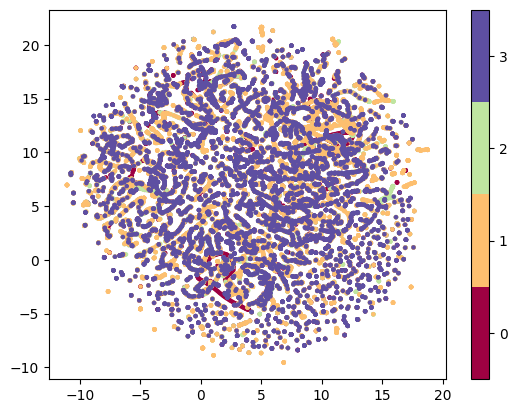

In [117]:
visualize_umap_2d(X_sliding, y_sliding, n_neighbors=5, min_dist=0.1)

/home/renan/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/renan/.local/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/renan/.local/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


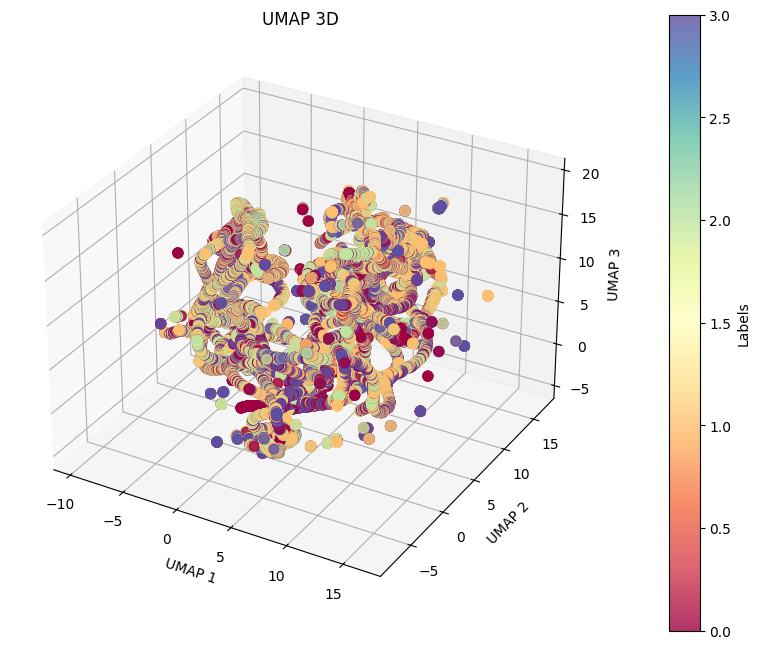

In [118]:
visualize_umap_3d(X_sliding, y_sliding, n_neighbors=15, min_dist=0.1, metric='euclidean', title='UMAP 3D')

## Random Forest

Trying training a random forest in the data to verify the performance

In [121]:
def fit_RF(X_train, X_test, y_train, y_test, n_estimators=100, random_state=42):
    clf = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return clf, classification_report(y_test, y_pred), y_pred

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X_sliding, y_sliding, test_size=0.2, random_state=42)

In [123]:
clf, report, y_pred = fit_RF(X_train, X_test, y_train, y_test)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.85      0.88      1882
           1       0.91      0.97      0.94      3252
           2       0.93      0.89      0.91      2582
           3       0.88      0.91      0.89      1729

    accuracy                           0.91      9445
   macro avg       0.91      0.90      0.90      9445
weighted avg       0.91      0.91      0.91      9445



## t-SNE

In [125]:
def visualize_tsne_2d(data, y_numeric, perplexity=30):
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    X_tsne = tsne.fit_transform(data)

    plt.figure(figsize=(10, 8))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_numeric, cmap='viridis', s=5)
    plt.colorbar(boundaries=np.arange(len(np.unique(y_numeric))+1)-0.5).set_ticks(np.arange(len(np.unique(y_numeric))))
    plt.title('t-SNE 2D Projection')
    plt.show()

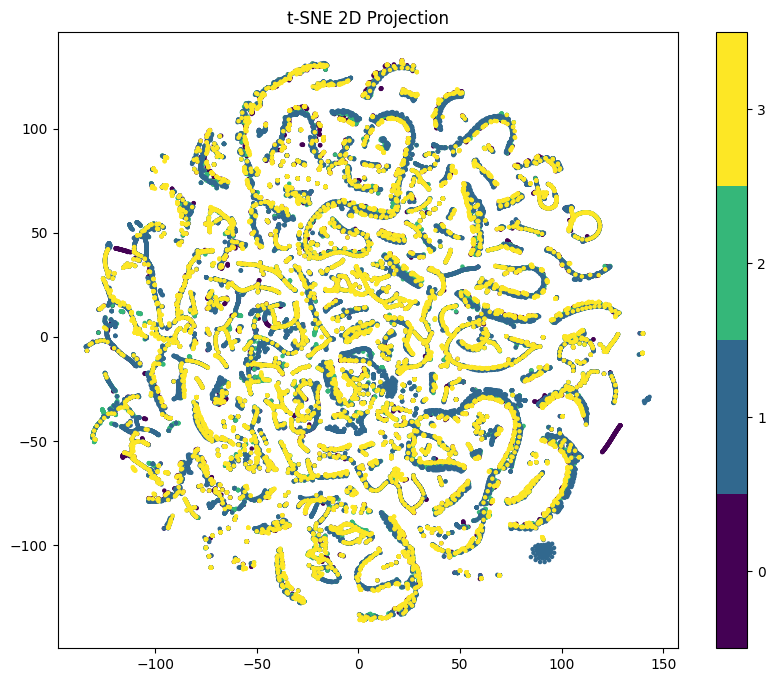

In [126]:
visualize_tsne_2d(X_sliding, y_sliding, perplexity=30)


## UMAP Extracting Features

In [22]:
X_features = extract_features(X, column_id='id')

Feature Extraction: 100%|██████████| 30/30 [01:57<00:00,  3.90s/it]


In [42]:
X_features_clean = X_features.dropna(axis=1)
X_features_clean = X_features_clean.replace([np.inf, -np.inf], np.nan)
X_features_clean = X_features_clean.fillna(X_features_clean.mean())

/home/renan/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/renan/.local/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/renan/.local/lib/python3.10/site-packages/umap/umap_.py:127: UserWarning: A few of your vertices were disconnected from the manifold.  This shouldn't cause problems.
Disconnection_distance = inf has removed 1274 edges.
It has only fully disconnected 1 vertices.
Use umap.utils.disconnected_vertices() to identify them.
  warn(


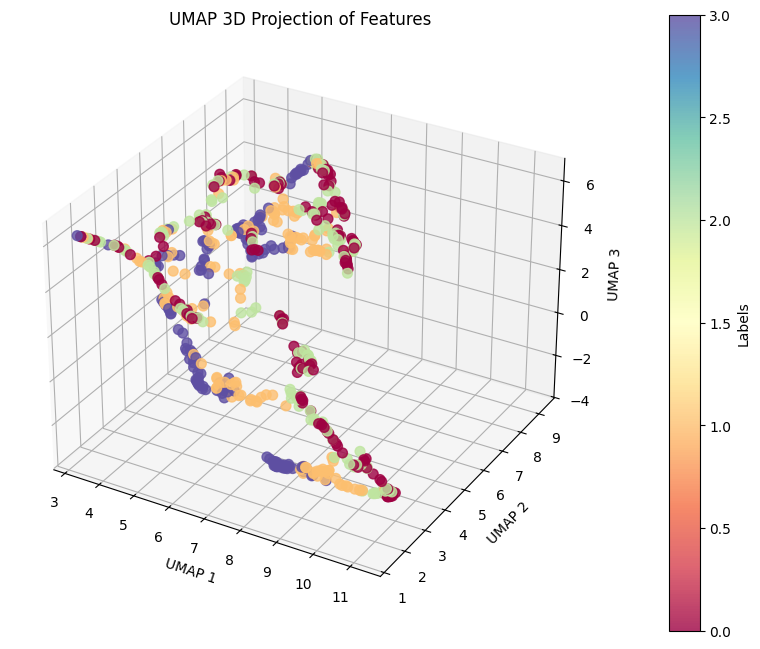

In [43]:
visualize_umap_3d(X_features_clean, labels=y_numeric, title="UMAP 3D Projection of Features")

In [9]:
X[0]

,time,x_pos,y_pos,speed,acceleration,angle
0,1,1408.586333,1168.512880,0.000000,0.000000,196.565039
1,2,1407.883422,1166.132628,2.482482,2.482482,196.509112
2,3,1406.293691,1160.839217,5.528327,3.045845,196.716162
3,4,1404.212695,1153.748721,7.391351,1.863024,196.356532
4,5,1401.259968,1143.852646,10.329753,2.938401,196.613699
...,...,...,...,...,...,...
127,128,2148.388079,1350.617880,10.160567,2.003646,294.888688
128,129,2136.863555,1355.809741,12.638946,2.478379,294.251800
129,130,2123.664306,1361.917493,14.542743,1.903797,294.831643
130,131,2109.589445,1368.390127,15.490724,0.947981,294.696384


/home/renan/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


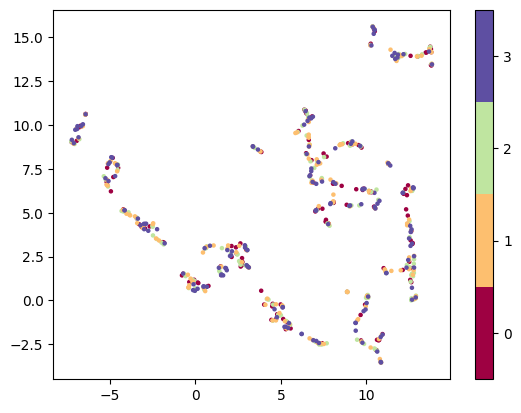

In [208]:
X_umap = umap.UMAP(n_neighbors=5, min_dist=0.1, n_components=2, metric='euclidean').fit_transform(features)
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y_numeric, cmap='Spectral', s=5)
plt.colorbar(boundaries=np.arange(len(np.unique(y_numeric))+1)-0.5).set_ticks(np.arange(len(np.unique(y_numeric))))
plt.show()

## t-SNE

In [240]:
distance_matrix = cdist_dtw(X)

KeyboardInterrupt: 

In [ ]:
visualize_umap_3d(distance_matrix, labels=y_numeric, title="UMAP 3D Projection of Features (DTW Distance)", metric="precomputed")

/home/renan/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/renan/.local/lib/python3.10/site-packages/umap/umap_.py:1857: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  warn(
/home/renan/.local/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


KeyboardInterrupt: 